In [1]:
%matplotlib inline

from datetime import datetime

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

import heliopy.data.helios as helios

import sys
sys.path.append('library')
import helpers_local
import helioshelp
import mplhelp

In [2]:
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['figure.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
figwidth = 12

In [4]:
starttime = datetime(1975, 1, 1)
endtime = datetime(1975, 6, 1)
probe = '1'
corefit = helios.corefit(probe, starttime, endtime, try_download=False).data
corefit = corefit.loc[corefit['r_sun'] < 0.5]

In [5]:
corefit = helioshelp.calculate_derived(corefit)

New keys:
 Index(['B instrument', 'Bx', 'By', 'Bz', 'sigma B', 'Ion instrument', 'Status',
       'Tp_par', 'Tp_perp', 'carrot', 'r_sun', 'clat', 'clong',
       'earth_he_angle', 'n_p', 'vp_x', 'vp_y', 'vp_z', 'vth_p_par',
       'vth_p_perp', '|B|', '|v|', 'Tp_tot', 'p_mag', 'p_th_par', 'p_th_tot',
       'Beta', 'Beta_tot', 'Tani', 'n_p_norm', 'mass_flux', 'Entropy', 'va_x',
       'va_y', 'va_z', '|va|'],
      dtype='object')


In [6]:
period = '20T'
donwsampled = corefit.resample(period, level='Time').mean()

In [7]:
corefit['Probe'] = '2'
probe_level = corefit.set_index('Probe', append=True)
vbs = probe_level[['vp_x', 'vp_y', 'vp_z', 'va_x', 'va_y', 'va_z']].dropna()
out = helioshelp.apply_downsampled_function(vbs, helpers_local.correl, '20T', 10)
out = [df.reset_index(level=1, drop=True) for df in out]

In [8]:
corefit['sigma_c'] = out[1].reindex(corefit.index)
donwsampled['sigma_c'] = out[0].reindex(donwsampled.index)
donwsampled['+_polarity'] = donwsampled['sigma_c'] > 1

# Create categories
donwsampled['category'] = np.nan
donwsampled.loc[donwsampled['Tani'] > 1.7, 'category'] = 1
donwsampled.loc[(donwsampled['Tani'] < 1.7) & (donwsampled['sigma_c'].abs() > 0.8), 'category'] = 2
donwsampled.loc[(donwsampled['Tani'] < 1.7) & (donwsampled['sigma_c'].abs() < 0.8), 'category'] = 3

In [9]:
aniso = donwsampled['Tani'] > 1.7
alfvenic = donwsampled['sigma_c'].abs() > 0.8

In [10]:
def tick_right(ax):
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

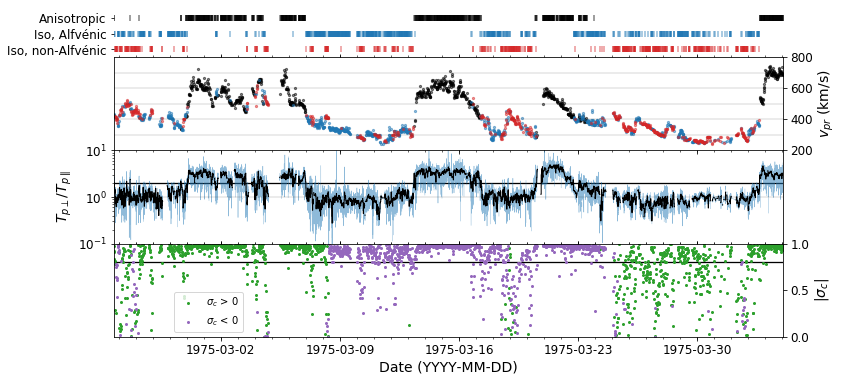

In [11]:
step_kwargs = {'linewidth': 1, 'where': 'post'}
hline_kwargs = {'color': 'k', 'linewidth': 1.3, 'zorder': -10}
# Start plotting
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 6),
                        gridspec_kw=dict(height_ratios=(0.5, 1, 1, 1)))
                        
fig.subplots_adjust(hspace=0)
axs[-1].set_xlabel('Date (YYYY-MM-DD)')

# Format category axis
ax_cat = axs[0]
def formatter(x, pos):
    try:
        return {1: 'Anisotropic', 2: 'Iso, Alfvénic', 3: 'Iso, non-Alfvénic'}[x]
    except KeyError:
        return ''
ax_cat.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))
ax_cat.set_ylim(3.5, 0.5)
ax_cat.spines["top"].set_visible(False)
ax_cat.spines["right"].set_visible(False)
ax_cat.spines["left"].set_visible(False)

# Plot velocity
ax = axs[1]
ckwargs = {'c': np.log10(corefit['Tani']),
           'cmap': 'coolwarm',
           'vmin': np.log10(2) - 0.5,
           'vmax': np.log10(2) + 0.5}
indices = (aniso & alfvenic,
           (~aniso) & alfvenic,
           (~aniso) & (~alfvenic))
labels = ('Anisotropic, Alfvénic',
          'Isotropic, Alfvénic',
          'Isotropic, non-Alfvénic')
colors = ('k', 'C0', 'C3')
for index, label, color in zip(indices, labels, colors):
    toplot = donwsampled.dropna(subset=('Tani', 'sigma_c'))
    toplot = toplot.loc[index]
    # Category scatter
    ax_cat.scatter(toplot.index, toplot['category'],
                   marker='|', c=color, alpha=0.5)
    # Velocity scatter
    ax.scatter(toplot.index, toplot['vp_x'],
               s=5, label=label, c=color, alpha=0.5)
for i in range(3, 9):
    ax.axhline(100 * i, color='k', alpha=0.4, lw=0.4)
ax.set_ylim(200, 800)
ax.xaxis.tick_top()
ax.set_ylabel(r'$v_{pr}$ (km/s)')
tick_right(ax)

ax = axs[2]
# Plot temperature anisotropy
ax.plot(corefit.index, corefit['Tani'], alpha=0.5, linewidth=0.5)
ax.step(donwsampled.index, donwsampled['Tani'],
            color='k', **step_kwargs)
ax.set_yscale('log')
ax.axhline(2, **hline_kwargs)
ax.set_ylim(1e-1, 1e1)
ax.set_ylabel(r'$T_{p\perp} / T_{p\parallel}$')
ax.axhline(1, color='k', alpha=0.4, lw=0.4)

# Plot cross correlations
ax = axs[3]
ax.scatter(donwsampled.index, donwsampled['sigma_c'],
               s=4, label='$\sigma_{c}$ > 0', color='C2')
ax.scatter(donwsampled.index, -donwsampled['sigma_c'],
               s=4, label='$\sigma_{c}$ < 0', color='C4')
ax.axhline(helpers_local.correl_cut, **hline_kwargs)
ax.set_ylim(0, 1)
ax.set_ylabel('|$\sigma_{c}$|')
ax.yaxis.tick_right()
tick_right(ax)
ax.legend(frameon=True, loc=(0.09, 0.05))

ax.set_xlim(corefit.index.min(), corefit.index.max())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))


# fig.align_ylabels()

for ax in axs[1:]:
    ax.xaxis.set_tick_params(which='both', direction='in',
                             bottom=True, top=True)
axs[1].xaxis.set_tick_params(which='both', top=True, direction='out')
axs[-1].xaxis.set_tick_params(which='both', bottom=True, direction='out')
fig.savefig('figure_6.pdf', bbox_inches='tight')